# Notes

Third iteration on the data - build transformer
- read data from json 
- a training/test split shall be based on patients


In [1]:
import os 
import re
import csv
import json
import random
from datetime import datetime

import math
import pandas as pd
import numpy as np
import tensorflow as tf

# Constants

In [2]:
SEQ_LEN = 500

X_MAX = 362.850308418274
X_MIN = -385.386139154434
Y_MAX = 407.209008932114
Y_MIN = -184.533506631851
Z_MAX = 1414.35980796814
Z_MIN = 465.504199266434

N_CLASSES = 6

In [3]:
region = {
    '0_LefteyeMidbottom': 'orbital', 
    '1_LefteyeMidtop': 'orbital',  
    '2_LefteyeInnercorner': 'orbital', 
    '3_LefteyeOutercorner': 'orbital',  
    '4_LefteyebrowInner': 'frontal', 
    '5_LefteyebrowCenter': 'frontal',  
    '6_RighteyeMidbottom': 'orbital',  
    '7_RighteyeMidtop': 'orbital', 
    '8_RighteyeInnercorner': 'orbital',  
    '9_RighteyeOutercorner': 'orbital', 
    '10_RighteyebrowInner': 'frontal', 
    '11_RighteyebrowCenter': 'frontal',  
    '12_NoseTip': 'nasal', 
    '13_MouthLowerlipMidbottom': 'oral',
    '14_MouthLeftcorner': 'oral',
    '15_MouthRightcorner': 'oral',
    '16_MouthUpperlipMidtop': 'oral',
    '17_ChinCenter': 'other', 
    '18_ForeheadCenter': 'frontal', 
    '19_LeftcheekCenter': 'other', 
    '20_RightcheekCenter': 'other',
}

pois_order = {
    '0_LefteyeMidbottom': 0,
    '1_LefteyeMidtop': 1,
    '2_LefteyeInnercorner': 2,
    '3_LefteyeOutercorner': 3,  
    '6_RighteyeMidbottom': 4,  
    '7_RighteyeMidtop': 5,
    '8_RighteyeInnercorner': 6,  
    '9_RighteyeOutercorner': 7,
    '4_LefteyebrowInner': 8,
    '5_LefteyebrowCenter': 8,
    '18_ForeheadCenter': 10,
    '10_RighteyebrowInner': 11,
    '11_RighteyebrowCenter': 12,
    '12_NoseTip': 13,
    '13_MouthLowerlipMidbottom': 14,
    '14_MouthLeftcorner': 15,
    '15_MouthRightcorner': 16,
    '16_MouthUpperlipMidtop': 17,
    '17_ChinCenter': 18,
    '19_LeftcheekCenter': 19,
    '20_RightcheekCenter': 20,
}

In [4]:
dir_data_root = os.path.join('data')
dir_data_source = os.path.join(dir_data_root, 'json')

# Data prep

Read every patien file in the target directory

In [5]:
data = {}

for file_name in os.listdir(dir_data_source):
    
    patient_id = file_name.split('.')[0]
    with open(os.path.join(dir_data_source, file_name)) as f:
        data[patient_id] = json.load(f)
        
        print('Loaded data for patient ID: %s' % patient_id)  


Loaded data for patient ID: 00000000082
Loaded data for patient ID: 00000000057
Loaded data for patient ID: 00000000000
Loaded data for patient ID: 00000000016
Loaded data for patient ID: 00000000041
Loaded data for patient ID: 00000000036
Loaded data for patient ID: 00000000061
Loaded data for patient ID: 00000000077
Loaded data for patient ID: 00000000020
Loaded data for patient ID: 00000000076
Loaded data for patient ID: 00000000060
Loaded data for patient ID: 00000000037
Loaded data for patient ID: 00000000040
Loaded data for patient ID: 00000000017
Loaded data for patient ID: 00000000001
Loaded data for patient ID: 00000000056
Loaded data for patient ID: 00000000083
Loaded data for patient ID: 00000000030
Loaded data for patient ID: 00000000067
Loaded data for patient ID: 00000000071
Loaded data for patient ID: 00000000026
Loaded data for patient ID: 00000000051
Loaded data for patient ID: 00000000006
Loaded data for patient ID: 00000000010
Loaded data for patient ID: 00000000047


In [6]:
patients = list(data.keys())

# Classification

## Data set per session

## Data obseravation

Get length of all measurements individualy at POIs levels

In [7]:
def key_pois(poi):
    return pois_order[poi['meta']['tag']]

In [8]:
signal_lens = []
for patient_id in data:
    for session in data[patient_id]:
        #print(patient_id)
        for excercise in session['exercises']: 
            xs_excercise = []
            pois_sorted = sorted(excercise['pois'], key = key_pois)
            for poi in pois_sorted:
                #print(len(poi['input']['x_normalized']))
                signal_lens.append(len(poi['input']['x_normalized']))

In [9]:
print('There are %s sequences for pois' % len(signal_lens))

There are 21609 sequences for pois


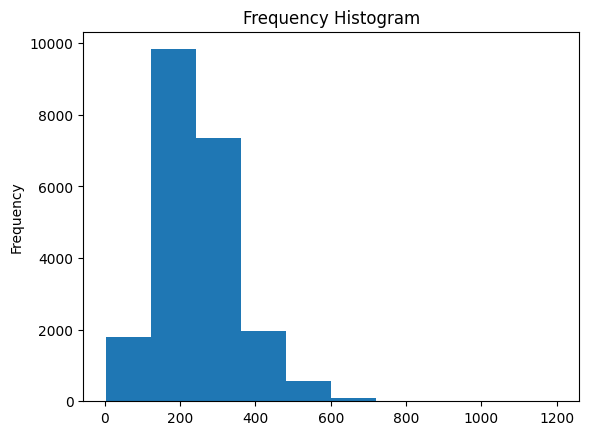

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

#plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
x = signal_lens
plt.hist(x)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');


##### Build training set

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [61]:
random.shuffle(patients)

len(patients)

81

In [69]:
training_patients = patients[:72]
validating_patients = []#patients[60:70]
testing_patients = patients[72:]

In [70]:
def fill_inputs(target_patients):
    target_xs = []
    target_ys = []
    
    for patient_id in target_patients:
        #print('Extracting sessions for patient: %s' % patient_id)

        for session in data[patient_id]:
            for excercise in session['exercises']: 
                xs_excercise = []
                pois_sorted = sorted(excercise['pois'], key = key_pois)
                for poi in pois_sorted:
                    #xs_excercise.append(poi['input']['x'])
                    #xs_excercise.append(poi['input']['y'])
                    #xs_excercise.append(poi['input']['z'])
                    #xs_excercise.append(poi['input']['dist'])
                    xs_excercise.append(poi['input']['x_normalized'])
                    xs_excercise.append(poi['input']['y_normalized'])
                    xs_excercise.append(poi['input']['z_normalized'])
                    xs_excercise.append(poi['input']['dist_normalized'])
                    xs_excercise.append(poi['input']['direction_angles'])
                    break
                target_xs.append(pad_sequences(
                    xs_excercise,
                    padding="pre",
                    dtype = 'f',
                    maxlen=SEQ_LEN))
                target_ys.append(session['meta']['evaluation'] - 1)
                break
            
    return target_xs, target_ys

### Class weights

In [71]:
from collections import Counter

In [72]:
_, classes_in_training = fill_inputs(training_patients)

freq_training_classes = Counter(classes_in_training) 

print(freq_training_classes)

weight_training_classes = {}
for class_id in freq_training_classes:
    weight_training_classes[class_id] = len(classes_in_training) / (N_CLASSES * freq_training_classes[class_id])

print(weight_training_classes)

Counter({0: 53, 1: 15, 2: 13, 5: 11, 3: 5, 4: 5})
{0: 0.32075471698113206, 2: 1.3076923076923077, 1: 1.1333333333333333, 3: 3.4, 5: 1.5454545454545454, 4: 3.4}


### Train, Val, Test sets generation

In [73]:
xs_train, ys_train = fill_inputs(training_patients)

xs_train = np.array(xs_train)
ys_train = np.array(ys_train)

print(xs_train.shape)
print(ys_train.shape)

(102, 5, 500)
(102,)


In [74]:
xs_val, ys_val = fill_inputs(validating_patients)
xs_val = np.array(xs_val)
ys_val = np.array(ys_val)

print(xs_val.shape)
print(ys_val.shape)

(0,)
(0,)


In [75]:
xs_test, ys_test = fill_inputs(testing_patients)
xs_test = np.array(xs_test)
ys_test = np.array(ys_test)

print(xs_test.shape)
print(ys_test.shape)

(17, 5, 500)
(17,)


## Modeling

In [76]:
from tensorflow import keras
from tensorflow.keras import layers

In [77]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [78]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(N_CLASSES, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [80]:
input_shape = xs_train.shape[1:]
print('Input shape: %s' % (str(input_shape)))

xs_input = layers.Input(shape=input_shape)

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25
)



#x = layers.LSTM(32, activation="relu")(xs_input)
#x = layers.Flatten()(xs_input)
#x = layers.Dense(16, activation="relu")(x)
#x = layers.Dense(6)(x)
#model = keras.Model(inputs=xs_input, outputs=x)

model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=keras.optimizers.Adam(lr=1e-3, decay=1e-3 / 200),
    metrics=['accuracy']
)

model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

Input shape: (5, 500)
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 5, 500)]     0           []                               
                                                                                                  
 layer_normalization_16 (LayerN  (None, 5, 500)      1000        ['input_9[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_8 (MultiH  (None, 5, 500)      2051572     ['layer_normalization_16[0][0]', 
 eadAttention)                                                    'layer_normalization_16[0][0]'] 
                                                                      

 ambda)                                                           'tf.__operators__.add_21[0][0]']
                                                                                                  
 layer_normalization_23 (LayerN  (None, 5, 500)      1000        ['tf.__operators__.add_22[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv1d_22 (Conv1D)             (None, 5, 4)         2004        ['layer_normalization_23[0][0]'] 
                                                                                                  
 dropout_25 (Dropout)           (None, 5, 4)         0           ['conv1d_22[0][0]']              
                                                                                                  
 conv1d_23 (Conv1D)             (None, 5, 500)       2500        ['dropout_25[0][0]']             
          

/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [82]:
model.fit(
    xs_train,
    ys_train,
    #validation_data=(xs_val, ys_val),
    epochs=200,
    batch_size=32,
    #callbacks=callbacks,
    class_weight=weight_training_classes
)

Epoch 1/200
2/2 [==============================] - 0s 112ms/step - loss: 0.4242 - accuracy: 0.8137
Epoch 2/200
2/2 [==============================] - 0s 115ms/step - loss: 0.5674 - accuracy: 0.7157
Epoch 3/200
2/2 [==============================] - 0s 112ms/step - loss: 0.4840 - accuracy: 0.7353
Epoch 4/200
2/2 [==============================] - 0s 112ms/step - loss: 0.3363 - accuracy: 0.8627
Epoch 5/200
2/2 [==============================] - 0s 114ms/step - loss: 0.4819 - accuracy: 0.7451
Epoch 6/200
2/2 [==============================] - 0s 108ms/step - loss: 0.3996 - accuracy: 0.8235
Epoch 7/200
2/2 [==============================] - 0s 110ms/step - loss: 0.8500 - accuracy: 0.8235
Epoch 8/200
2/2 [==============================] - 0s 112ms/step - loss: 0.4247 - accuracy: 0.8137
Epoch 9/200
2/2 [==============================] - 0s 109ms/step - loss: 0.5569 - accuracy: 0.7255
Epoch 10/200
2/2 [==============================] - 0s 107ms/step - loss: 0.3227 - accuracy: 0.7745
Epoch 11/

2/2 [==============================] - 0s 112ms/step - loss: 0.2688 - accuracy: 0.8431
Epoch 84/200
2/2 [==============================] - 0s 121ms/step - loss: 0.2765 - accuracy: 0.8725
Epoch 85/200
2/2 [==============================] - 0s 112ms/step - loss: 0.4756 - accuracy: 0.7549
Epoch 86/200
2/2 [==============================] - 0s 120ms/step - loss: 0.3563 - accuracy: 0.8725
Epoch 87/200
2/2 [==============================] - 0s 117ms/step - loss: 0.3522 - accuracy: 0.8431
Epoch 88/200
2/2 [==============================] - 0s 113ms/step - loss: 0.3732 - accuracy: 0.7843
Epoch 89/200
2/2 [==============================] - 0s 106ms/step - loss: 0.3274 - accuracy: 0.8529
Epoch 90/200
2/2 [==============================] - 0s 111ms/step - loss: 0.4139 - accuracy: 0.7745
Epoch 91/200
2/2 [==============================] - 0s 118ms/step - loss: 0.2163 - accuracy: 0.8627
Epoch 92/200
2/2 [==============================] - 0s 106ms/step - loss: 0.4091 - accuracy: 0.7353
Epoch 93/200


2/2 [==============================] - 0s 117ms/step - loss: 0.0735 - accuracy: 0.9706
Epoch 165/200
2/2 [==============================] - 0s 109ms/step - loss: 0.1115 - accuracy: 0.9510
Epoch 166/200
2/2 [==============================] - 0s 109ms/step - loss: 0.1321 - accuracy: 0.9412
Epoch 167/200
2/2 [==============================] - 0s 107ms/step - loss: 0.0976 - accuracy: 0.9804
Epoch 168/200
2/2 [==============================] - 0s 109ms/step - loss: 0.1945 - accuracy: 0.9510
Epoch 169/200
2/2 [==============================] - 0s 113ms/step - loss: 0.1096 - accuracy: 0.9510
Epoch 170/200
2/2 [==============================] - 0s 114ms/step - loss: 0.1904 - accuracy: 0.9608
Epoch 171/200
2/2 [==============================] - 0s 114ms/step - loss: 0.0805 - accuracy: 0.9706
Epoch 172/200
2/2 [==============================] - 0s 104ms/step - loss: 0.0623 - accuracy: 0.9804
Epoch 173/200
2/2 [==============================] - 0s 109ms/step - loss: 0.0677 - accuracy: 0.9608
Epoc

In [83]:
xs_test.shape

(17, 5, 500)

In [84]:
model.evaluate(xs_test, ys_test, verbose=2)

2023-01-12 21:54:38.109982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 - 1s - loss: 12.3817 - accuracy: 0.1765 - 685ms/epoch - 685ms/step


[12.381667137145996, 0.1764705926179886]

In [85]:
from sklearn.metrics import classification_report

y_pred = model.predict(xs_test, batch_size=8, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(ys_test, y_pred_bool))

2023-01-12 21:54:38.799268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 2s 514ms/step
              precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         0
           5       0.29      0.50      0.36         4

    accuracy                           0.18        17
   macro avg       0.10      0.12      0.10        17
weighted avg       0.17      0.18      0.16        17



/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

In [86]:
y_pred


array([[1.51223065e-02, 8.13481105e-09, 2.73521655e-05, 1.18203280e-09,
        4.11051745e-03, 9.80739832e-01],
       [8.49573731e-01, 3.82921584e-02, 9.77483168e-02, 6.54317701e-05,
        8.20849527e-06, 1.43121416e-02],
       [1.48190102e-02, 9.89236426e-09, 2.99726871e-05, 1.06367748e-09,
        3.09361564e-03, 9.82057452e-01],
       [4.07170365e-03, 8.00541800e-10, 6.95875585e-02, 3.37780136e-07,
        6.97103202e-01, 2.29237139e-01],
       [9.97612596e-01, 2.74653605e-04, 2.11255392e-03, 2.26745087e-15,
        7.77312818e-15, 1.47845000e-07],
       [4.47751358e-02, 8.72171223e-01, 8.30435008e-02, 2.70830469e-06,
        8.62710403e-10, 7.49804212e-06],
       [1.90771278e-02, 1.27181847e-05, 1.98732642e-03, 2.64275532e-05,
        2.89272040e-01, 6.89624369e-01],
       [1.40062077e-02, 5.87604927e-06, 1.19623251e-03, 1.29837308e-05,
        3.15351099e-01, 6.69427633e-01],
       [1.00000000e+00, 7.57765754e-15, 2.68285588e-10, 5.51681910e-29,
        1.15380387e-29, 

__END__